# Feature Extraction in the Time Domain

In [1]:
# Goal: Practice generating some time-domain features and generating waveforms

# Tasks include:
# -	Load audio
# -	Visualize waveforms
# -	Extract and visualize time-domain amplitude envelope, root mean square energy, zero-crossing rate
# -	Use amplitude envelope in simple VAD-like task (extract a single quack from a duck audio) 

# Audio used:
# - Conversation
# - Singing
# - Duck quacking

# Date last updated: 1/21/2025
# Author: Kay Rubio

In [2]:
# Check python version for compatibility with librosa
!python3 --version

Python 3.12.8


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf

## Import and explore audio

In [4]:
# Load audio
audio_folder = "Sounds/sample_audios/"

# Librosa.load automatically resamples at sr=22050
convo, sr = librosa.load(audio_folder+"convo.wav") # example human convo
singing, _ = librosa.load(audio_folder+"singingwoman.wav") # example human singing
duck, _ = librosa.load(audio_folder+"duck.wav") # example simple animal sound

In [5]:
# Check the sample rate, should be librosa default of 22050
sr

22050

In [96]:
# Listen to audio files in notebook using IPython.display
# ipd.Audio(audio_folder+"convo.wav")

In [97]:
# ipd.Audio(audio_folder+"singingwoman.wav")

In [98]:
# ipd.Audio(audio_folder+"duck.wav")

In [9]:
# Check the shape of an audio file, which should show total number of samples
convo.shape

(285114,)

In [10]:
singing.shape

(288346,)

In [11]:
duck.shape

(265484,)

In [12]:
# Check the sample duration
sample_duration = 1 / sr
print(f"One sample of audio lasts for {sample_duration:.7f} seconds with sampling rate of {sr}")

One sample of audio lasts for 0.0000454 seconds with sampling rate of 22050


In [13]:
# Check total length of audio files in seconds
duration_convo = 1 / sr * len(convo)
print(f"The convo audio lasts for {duration_convo:.2f} seconds")
duration_singing = 1 / sr * len(singing)
print(f"The singing audio lasts for {duration_singing:.2f} seconds")
duration_duck = 1 / sr * len(duck)
print(f"The duck audio lasts for {duration_duck:.2f} seconds")

The convo audio lasts for 12.93 seconds
The singing audio lasts for 13.08 seconds
The duck audio lasts for 12.04 seconds


## Helper methods to plot waveforms

In [54]:
# Function to plot 1 waveform with optional line
def plotWaveform(audio, title, t=[], line=[], color="r"):
    plt.figure(figsize=(15, 3))
    librosa.display.waveshow(audio, sr=sr, alpha=0.5)
    plt.plot(t, line, color=color)
    plt.title(title)
    plt.xlabel("Time (sec)") 
    plt.ylabel("Amplitude")
    plt.show()

In [55]:
# Function to plot multiple waveforms in 1 figure
# audios and titles should be arrays of equal length
# also assumes sr is already defined as variable sr
def plotWaveforms(audios, titles):
    if(len(audios) != len(titles)):
        raise ValueError(f"Error: audios and titles should be arrays of the same length")
    num_of_waves = len(audios)
    plt.figure(figsize=(15, 8))
    for i, audio in enumerate(audios):
        plt.subplot(num_of_waves, 1, i+1) # create subplots of 3 files
        librosa.display.waveshow(audio, sr=sr, alpha=0.5)
        plt.title(titles[i])
    plt.subplots_adjust(hspace=0.5)  # Increase vertical spacing for titles
    plt.show()

## Plot waveforms

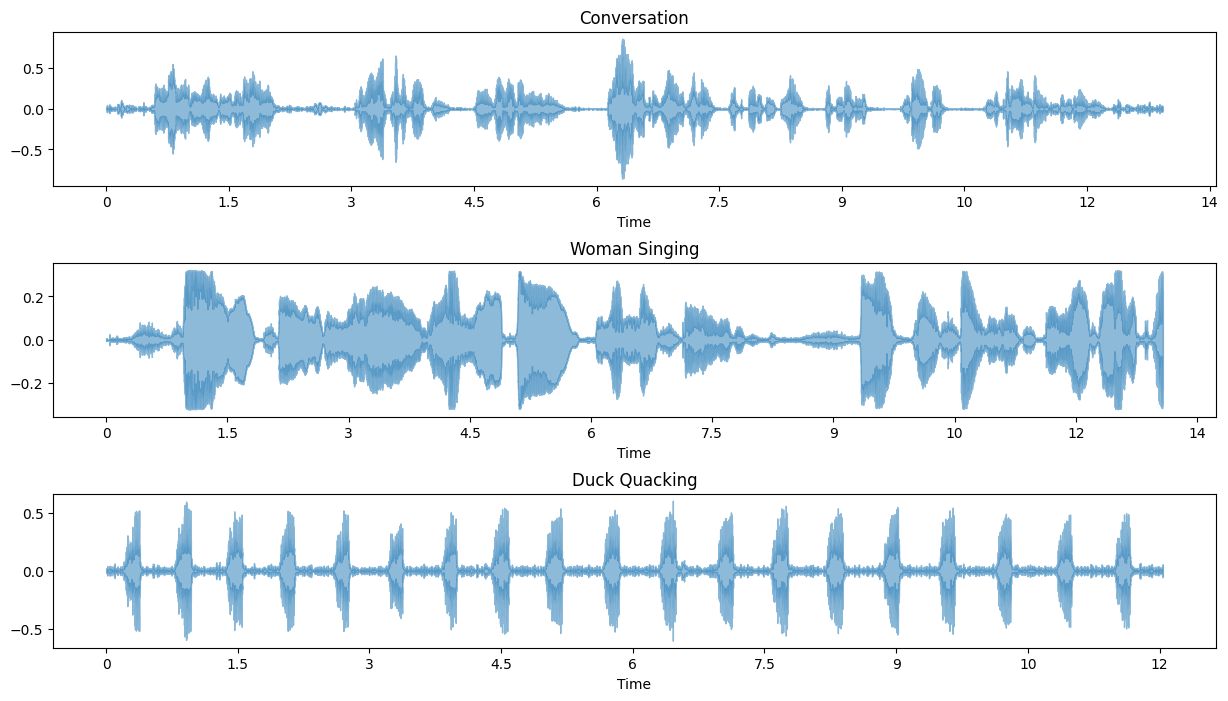

In [56]:
audios = [convo, singing, duck]
titles = ["Conversation", "Woman Singing", "Duck Quacking"]
plotWaveforms(audios, titles)

## Amplitude Envelope

In [34]:
FRAME_SIZE = 1024
HOP_LENGTH = 512

In [35]:
# Function to calculate amplitude envelope for each frame
def amplitude_envelope(audio, frame_size, hop_length):
    return np.array([max(audio[i:i+frame_size]) for i in range(0, len(audio), hop_length)])

In [36]:
# Calculate Amplitude Envelopes on the 3 audio files and check length of the result
ae_convo = amplitude_envelope(convo, FRAME_SIZE, HOP_LENGTH)
ae_singing = amplitude_envelope(singing, FRAME_SIZE, HOP_LENGTH)
ae_duck = amplitude_envelope(duck, FRAME_SIZE, HOP_LENGTH)
len(ae_duck)

519

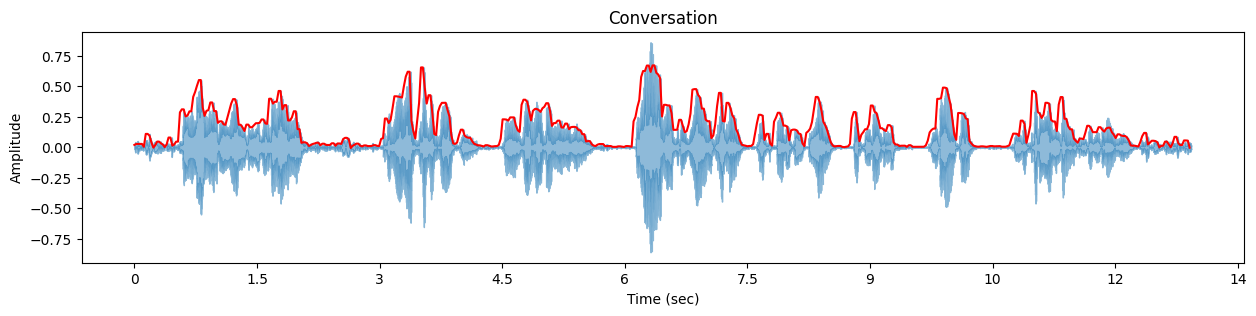

In [58]:
# Draw amplitude envelope onto waveform
frames = range(len(ae_convo))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)
plotWaveform(convo, "Conversation", t, ae_convo)

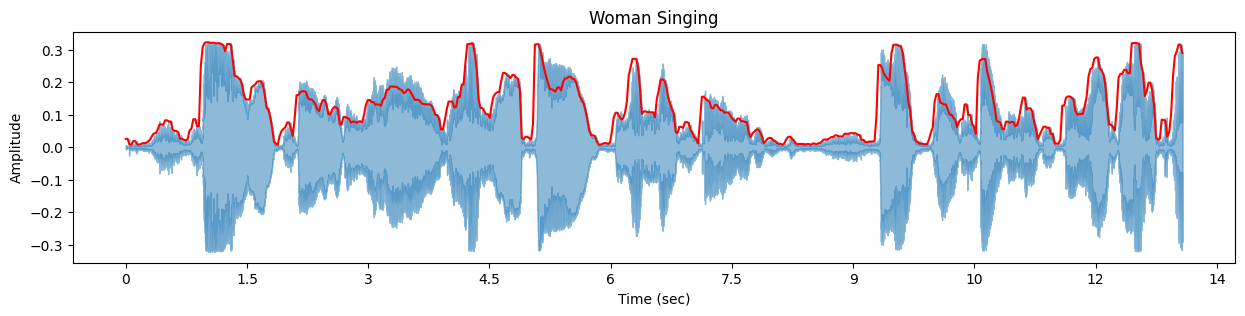

In [59]:
frames = range(len(ae_singing))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)
plotWaveform(singing, "Woman Singing", t, ae_singing)

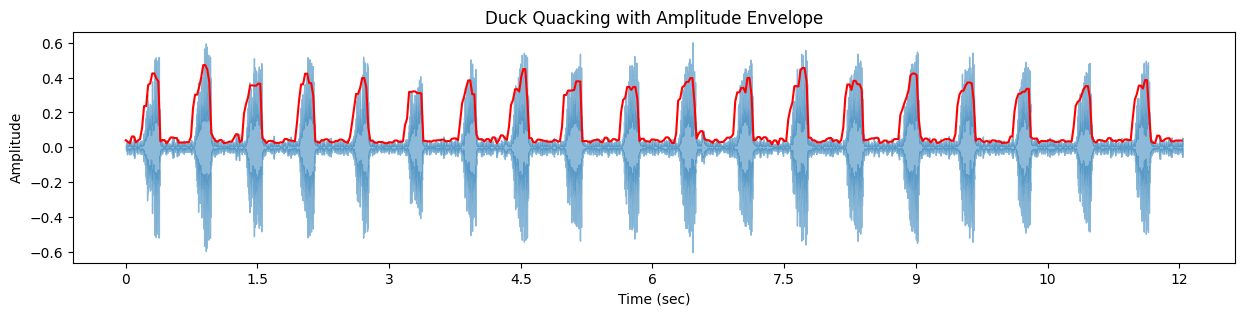

In [87]:
frames = range(len(ae_duck))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)
plotWaveform(duck, "Duck Quacking with Amplitude Envelope", t, ae_duck)

### Use amplitude envelope to isolate a single quack

In [61]:
# Practice of using AE for a simple VAD implementation (see VAD mini-project for more advanced 
# methods of isolating sounds

# From the diagram above, a quack could be considered to frames with values above 0.08, where frames 
# with AE's below 0.08 are just background noise. Looking at the AE values for the first 20 frames:
ae_duck[:20]

array([0.04020426, 0.03039332, 0.02253707, 0.06173735, 0.06173735,
       0.02760175, 0.03868768, 0.04716518, 0.10967383, 0.23637499,
       0.23637499, 0.35772783, 0.36630195, 0.42388   , 0.42388   ,
       0.39554363, 0.37775105, 0.03371273, 0.04104405, 0.04104405],
      dtype=float32)

In [74]:
cutoff = 0.14
start_frame = int(np.argmax(ae_duck > cutoff))-1
start_frame

8

In [80]:
# To find the end of the first quack, find the first value after the starting frame that is below
# the cutoff, then take the one right before it that was still above the cutoff
end_frame = int(np.argmax(ae_duck[start_frame + 1:] < cutoff) + (start_frame))
end_frame

16

In [81]:
# Trim audio file to just one quack using these starting and ending frames
# Convert frame indices to sample indices
start_sample = start_frame * HOP_LENGTH
end_sample = (end_frame * HOP_LENGTH) + FRAME_SIZE

In [82]:
# Trim the audio and check duration in seconds
duck_trimmed = duck[start_sample:end_sample]
duration_duck_trimmed = 1 / sr * len(duck_trimmed)
print(f"The duck quack lasts for {duration_duck_trimmed:.3f} seconds")

The duck quack lasts for 0.232 seconds


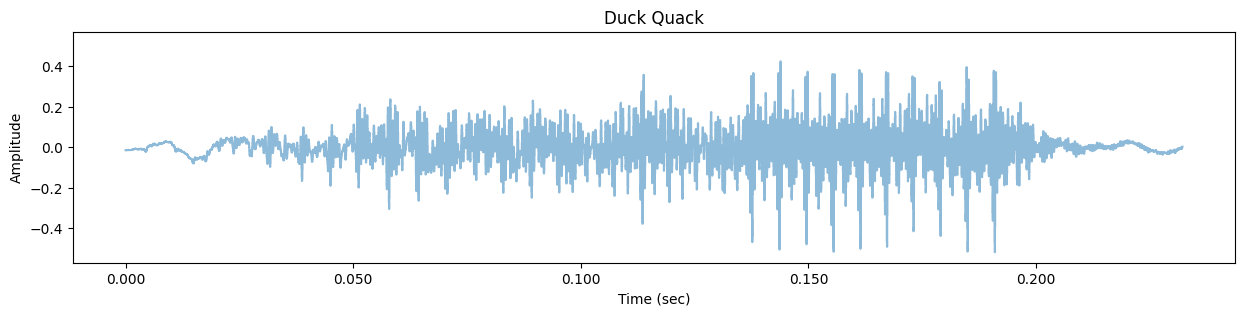

In [83]:
# Plot the quack
plotWaveform(duck_trimmed, "Duck Quack")

## Root Mean Square Energy

In [84]:
# Calculate rms as array using librosa.feature.rms and check the size of the resulting array
rms_convo = librosa.feature.rms(y=convo, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
rms_singing = librosa.feature.rms(y=singing, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
rms_duck = librosa.feature.rms(y=duck, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
len(rms_duck)

519

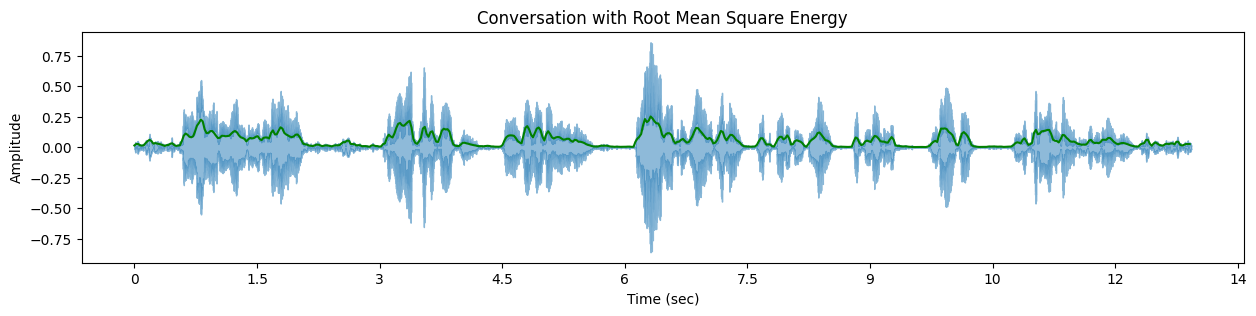

In [94]:
# Draw RMS onto waveform
frames = range(len(rms_convo))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)
plotWaveform(convo, "Conversation with Root Mean Square Energy", t, rms_convo, "g")

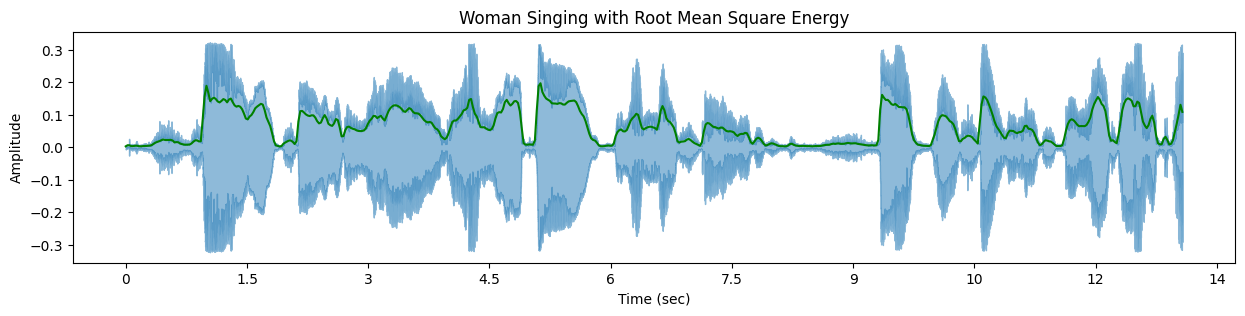

In [93]:
# Draw RMS onto waveform
frames = range(len(rms_singing))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)
plotWaveform(singing, "Woman Singing with Root Mean Square Energy", t, rms_singing, "g")

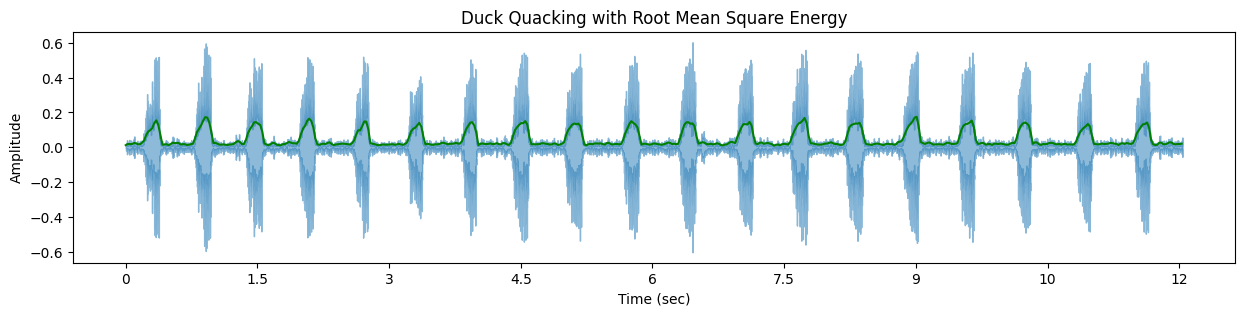

In [92]:
# Draw RMS onto waveform
frames = range(len(rms_duck))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)
plotWaveform(duck, "Duck Quacking with Root Mean Square Energy", t, rms_duck, "g")

## Zero-crossing rate

In [91]:
zcr_convo = librosa.feature.zero_crossing_rate(y=convo, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
zcr_singing = librosa.feature.zero_crossing_rate(y=singing, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
zcr_duck = librosa.feature.zero_crossing_rate(y=duck, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
len(zcr_duck)

519

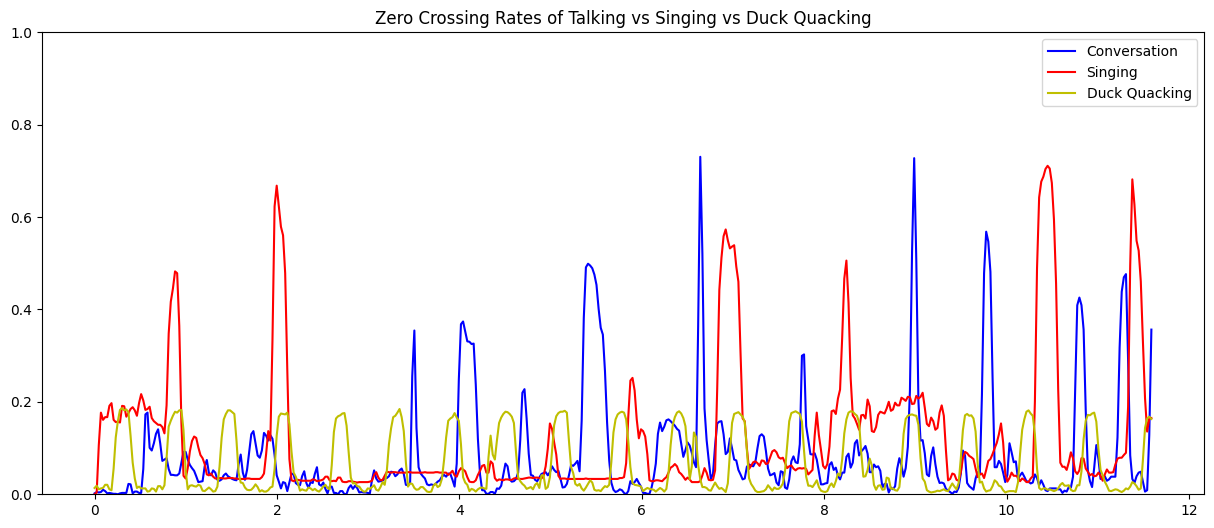

In [95]:
#Comparing the zero crossing rate of 3 different audio files
# For plotting purposes, use only first 500 frames
plt.figure(figsize=(15, 6))
plt.plot(t[:500], zcr_convo[:500], color="b", label="Conversation")
plt.plot(t[:500], zcr_singing[:500], color="r", label="Singing")
plt.plot(t[:500], zcr_duck[:500], color="y", label="Duck Quacking")
plt.ylim(0, 1)
plt.title("Zero Crossing Rates of Talking vs Singing vs Duck Quacking")
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Here you can see that the duck quacking has the lowest ZCR, while singing and conversation are
# comparable

## Save new file

In [ ]:
sf.write('duck_quack.wav',duck_trimmed, sr)